In [ ]:
!pip install pvlib
!apt install swig cmake 
!pip install stable-baselines3[extra] box2d box2d-kengz

## Download the folder "BEAR" and upload it to your Drive in "My Drive", then run the cells

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/BEAR/Models")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from building_HVAC import BuildingEnvReal
from MPC_Controller import MPCAgent
from bldg_utils import ParameterGenerator
import numpy as np
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

We start by creating an environment with a OfficeSmall type building at Tucson, and setting the weather type as Hot Dry:

In [ ]:
Parameter=ParameterGenerator('OfficeSmall','Hot_Dry','Tucson') #Description of ParameterGenerator in bldg_utils.py
env = BuildingEnvReal(Parameter)

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################


In [ ]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  10
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


###No Action

We first test the environment with no actions. Let's loop for 24 hours and plot the temperature and energy comsumption of each zones :

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]


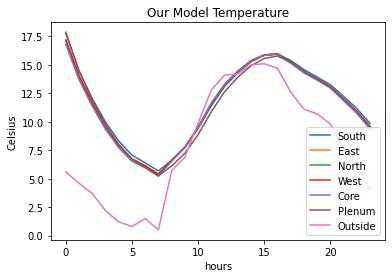

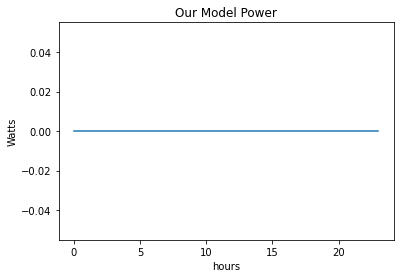

In [ ]:

numofhours=24
env.reset()
a=env.action_space.sample()
for i in range(numofhours):
    a = a*0
    obs, r, done, _ = env.step(a)
plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')

plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))

plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

In [ ]:
print('zone temerature:', np.array(env.statelist)[0,:-4])

zone temerature: [17.75179317 17.07085633 17.14668666 17.19433022 16.78964807 17.86825243]


###MPC

Then we use a MPC controller and set each room at 22 degrees:

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]


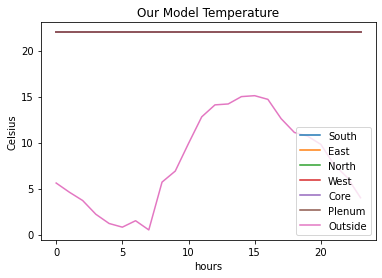

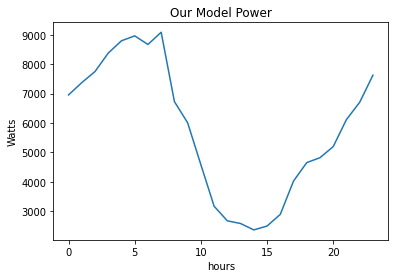

In [ ]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
numofhours=24
for i in range(numofhours):
    a,s = agent.predict(env)
    obs, r, done, _ = env.step(a)

plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()
MPCstate=env.statelist
MPCaction=env.actionlist

In [ ]:
print('zone temerature:', np.array(env.statelist)[0,:-4])

zone temerature: [22. 22. 22. 22. 22. 22.]


### Reinforcement Learning

Finally, we use a PPO controller to demonstrate RL usage. We perform a quick train with default settings and save the model:

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure

# from stable_baselines.bench import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env
seed=25
env.reset()
set_random_seed(seed=seed)
model = PPO("MlpPolicy", env, verbose=1)
rewardlist=[]
obs = env.reset()
for i in range(300):  
  model.learn(total_timesteps=1000, eval_freq=1000,reset_num_timesteps=True)
  rw=0
  obs = env.reset()
  for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    rw+=rewards
  print(rw/24)
  rewardlist.append(rw/24)
print("################TRAINING is Done############")
model.save("PPO_quick")
del model

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
-----------------------------
| time/              |      |
|    fps             | 753  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
-25.476847135318806
Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
-----------------------------
| time/              |      |
|    fps   

Then, we load the model and see the performance of the state and action:

Reset [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]
Initial observation [22.         22.         22.         22.         22.         22.
  5.6         0.         20.9         0.07849557]


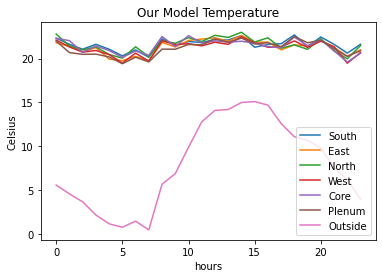

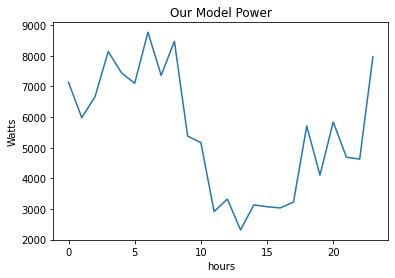

In [ ]:
model = PPO.load("PPO_quick")
obs = env.reset()
print("Initial observation", obs)

for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
plt.plot(np.array(env.statelist)[:,:-3])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

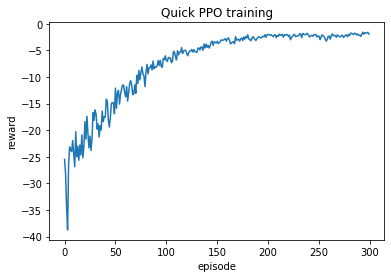

In [ ]:
plt.title('Quick PPO training')
plt.plot(rewardlist)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [ ]:
env.close()